# Extract Satellite Image

Using the `sentinelhub-py` package, a true color satellite image of area of interest (AOI) is extracted. Only <b> one mosaicked image </b> is returned for a requested time interval. The following sections demonstrate extraction within provided geographical locations (e.g. administrative boundaries).

## Credentials and Imports

In [18]:
from sentinelhub import SHConfig


INSTANCE_ID = '9d7bf4be-1cc4-4bcb-be32-69740b8f35b7'  # In case you put instance ID into configuration file you can leave this unchanged

if INSTANCE_ID:
    config = SHConfig()
    config.instance_id = INSTANCE_ID
else:
    config = None

In [19]:
import os
import datetime
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd

from sentinelhub import MimeType, CRS, BBox, Geometry, SentinelHubRequest, SentinelHubDownloadClient, \
    DataCollection, bbox_to_dimensions, DownloadRequest


In [20]:
def plot_image(image, factor=1.0, clip_range = None, **kwargs):
    """
    Utility function for plotting RGB images.
    """
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 15))
    if clip_range is not None:
        ax.imshow(np.clip(image * factor, *clip_range), **kwargs)
    else:
        ax.imshow(image * factor, **kwargs)
    ax.set_xticks([])
    ax.set_yticks([])

## Set area of interest (AOI)

AOI can be requested in two ways:<br> 
* **Bounding Box**
* **Geometry**

The Bounding Box should contain the longitude and latitude coordinates of lower left and upper right corners of AOI. These can be obtained using the bboxfinder. The Geometry takes in polygon values (e.g. shapefile, geojson)

### Example 1: NCR (Geometry)

In [21]:
# read ncr shapefile in geopandas
ncr = gpd.read_file("ncr-boundary/ncr-boundary.shp")

In [22]:
ncr.head()

Shape_Leng  Shape_Area                  ADM1_EN   ADM1_PCODE ADM1_REF  \
0    2.320234    0.050216  National Capital Region  PH130000000     None   

  ADM1ALT1EN ADM1ALT2EN            ADM0_EN ADM0_PCODE  \
0        NCR       None  Philippines (the)         PH   

                       date                   validOn  \
0  2016-06-30T00:00:00.000Z  2020-05-29T00:00:00.000Z   

                    validTo split_id  \
0  1899-11-30T00:00:00.000Z        1   

                                            geometry  
0  POLYGON ((121.09951 14.76921, 121.09940 14.768...

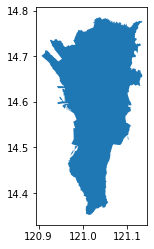

In [23]:
ncr.plot()

In [24]:
# check projection, should be set to epsg:4326 (WGS84) 
print(ncr.crs)

epsg:4326


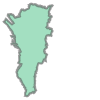

In [25]:
ncr['geometry'][0]

In [28]:
# initialize Geometry of AOI
ncr_geometry = Geometry(ncr.geometry.values[0], crs=CRS.WGS84)

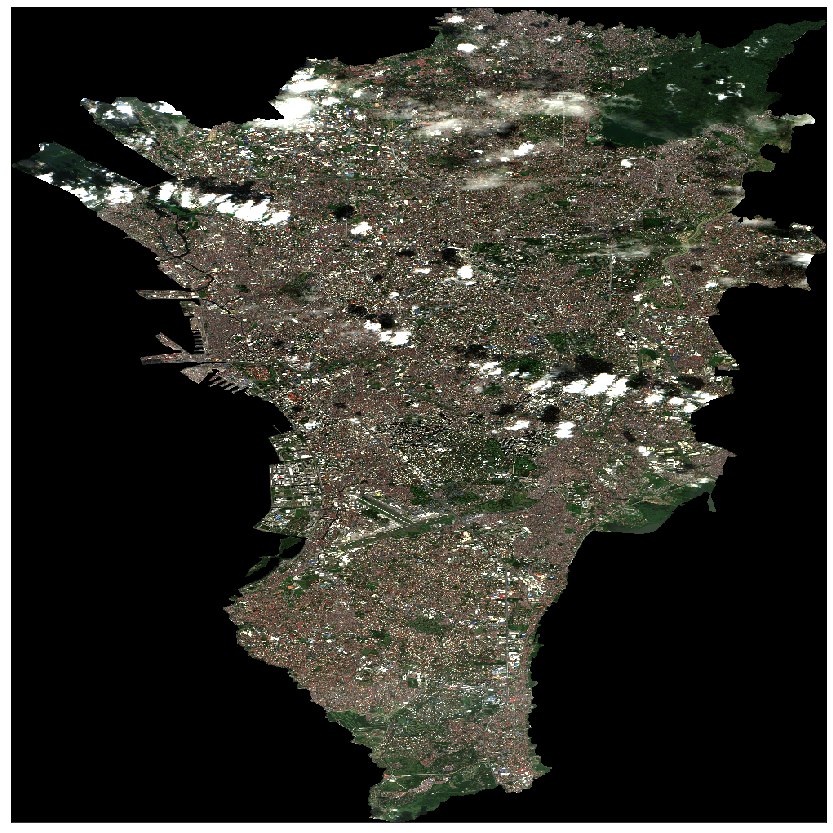

In [29]:
# evalscript for selecting appropriate bands
evalscript_true_color = """
    //VERSION=3
    function setup() {
        return {
            input: [{
                bands: ["B02", "B03", "B04"]
            }],
            output: {
                bands: 3
            }
        };
    }
    function evaluatePixel(sample) {
        return [sample.B04, sample.B03, sample.B02];
    }
"""

# build request to extract image
request = SentinelHubRequest(
    evalscript=evalscript_true_color,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L2A,
            time_interval=('2020-12-01', '2020-12-31'),
            mosaicking_order='leastCC'
        )
    ],
    responses=[
        SentinelHubRequest.output_response('default', MimeType.PNG)
    ],
    geometry=ncr_geometry,
    size=(1000,1000),    
    config=config
)

image = request.get_data()[0]

# extract true color image of least cloudy acquisitions (tile-level)
plot_image(image, factor=3.5/255, clip_range=(0,1))

### Example 2: CALABARZON (Geometry)

In [16]:
# read geojson file in geopandas
region = gpd.read_file('regional.json')
region

Shape_Leng  Shape_Area                               ADM1_EN   ADM1_PCODE  \
0    53.623497    1.050272  Autonomous Region in Muslim Mindanao  PH150000000   
1     8.027454    1.546712      Cordillera Administrative Region  PH140000000   
2     2.320234    0.050216               National Capital Region  PH130000000   
3    14.995101    1.043983                              Region I  PH010000000   
4    19.139048    2.241812                             Region II  PH020000000   
5    15.949563    1.793513                            Region III  PH030000000   
6    27.624115    1.326710                           Region IV-A  PH040000000   
7    78.804542    2.220374                           Region IV-B  PH170000000   
8    23.181441    1.196677                             Region IX  PH090000000   
9    44.923243    1.446324                              Region V  PH050000000   
10   27.589382    1.657135                             Region VI  PH060000000   
11   29.113105    1.178431                            Region VII  PH070000000   
12   42.021179    1.726804                           Region VIII  PH080000000   
13   15.002953    1.435115                              Region X  PH100000000   
14   17.934222    1.539971                             Region XI  PH110000000   
15   13.229749    1.471068                            Region XII  PH120000000   
16   28.166754    1.540820                           Region XIII  PH160000000   

   ADM1_REF           ADM1ALT1EN ADM1ALT2EN            ADM0_EN ADM0_PCODE  \
0                           ARMM             Philippines (the)         PH   
1                            CAR             Philippines (the)         PH   
2                            NCR             Philippines (the)         PH   
3                  Ilocos Region             Philippines (the)         PH   
4                 Cagayan Valley             Philippines (the)         PH   
5                  Central Luzon             Philippines (the)         PH   
6                     Calabarzon             Philippines (the)         PH   
7                       Mimaropa             Philippines (the)         PH   
8            Zamboanga Peninsula             Philippines (the)         PH   
9                   Bicol Region             Philippines (the)         PH   
10               Western Visayas             Philippines (the)         PH   
11               Central Visayas             Philippines (the)         PH   
12               Eastern Visayas             Philippines (the)         PH   
13             Northern Mindanao             Philippines (the)         PH   
14                  Davao Region             Philippines (the)         PH   
15                  Soccsksargen             Philippines (the)         PH   
16                        Caraga             Philippines (the)         PH   

                         date                    validOn  \
0   2016-06-30T00:00:00+00:00  2020-05-29T00:00:00+00:00   
1   2016-06-30T00:00:00+00:00  2020-05-29T00:00:00+00:00   
2   2016-06-30T00:00:00+00:00  2020-05-29T00:00:00+00:00   
3   2016-06-30T00:00:00+00:00  2020-05-29T00:00:00+00:00   
4   2016-06-30T00:00:00+00:00  2020-05-29T00:00:00+00:00   
5   2016-06-30T00:00:00+00:00  2020-05-29T00:00:00+00:00   
6   2016-06-30T00:00:00+00:00  2020-05-29T00:00:00+00:00   
7   2016-06-30T00:00:00+00:00  2020-05-29T00:00:00+00:00   
8   2016-06-30T00:00:00+00:00  2020-05-29T00:00:00+00:00   
9   2016-06-30T00:00:00+00:00  2020-05-29T00:00:00+00:00   
10  2016-06-30T00:00:00+00:00  2020-05-29T00:00:00+00:00   
11  2016-06-30T00:00:00+00:00  2020-05-29T00:00:00+00:00   
12  2016-06-30T00:00:00+00:00  2020-05-29T00:00:00+00:00   
13  2016-06-30T00:00:00+00:00  2020-05-29T00:00:00+00:00   
14  2016-06-30T00:00:00+00:00  2020-05-29T00:00:00+00:00   
15  2016-06-30T00:00:00+00:00  2020-05-29T00:00:00+00:00   
16  2016-06-30T00:00:00+00:00  2020-05-29T00:00:00+00:00   

                      validTo  \
0   1899-11-30T00:00:00+00:00   
1   1899-11

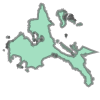

In [17]:
calabarzon = region['geometry'][6]
calabarzon

In [13]:
# initialize Geometry of AOI
calabarzon_geometry = Geometry(calabarzon, crs=CRS.WGS84)

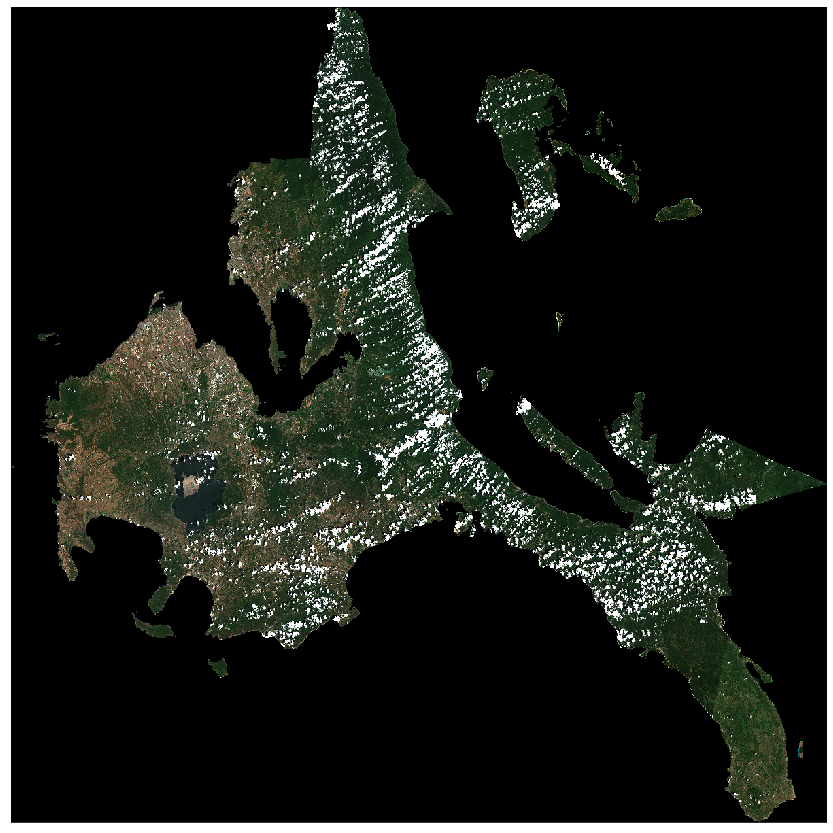

In [14]:
# build request to extract image
request = SentinelHubRequest(
    evalscript=evalscript_true_color,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L2A,
            time_interval=('2020-03-01', '2020-05-31'),
            mosaicking_order='leastCC'
        )
    ],
    responses=[
        SentinelHubRequest.output_response('default', MimeType.PNG)
    ],
    geometry=calabarzon_geometry,
    size=(1200,1200),
    config=config
)

image = request.get_data()[0]

plot_image(image, factor=3.5/255, clip_range=(0,1))

### Example 3: Mayon (Bounding Box)

In [15]:
# initialize bounding box of AOI
mayon = BBox([123.644806,13.213101,123.734241,13.290922], CRS.WGS84)

In [16]:
# set resolution
resolution =10
mayon_bbox = BBox(bbox=mayon, crs=CRS.WGS84)
mayon_size = bbox_to_dimensions(mayon_bbox, resolution=resolution)

print(f'Image shape at {resolution} m resolution: {mayon_size} pixels')

Image shape at 10 m resolution: (967, 863) pixels


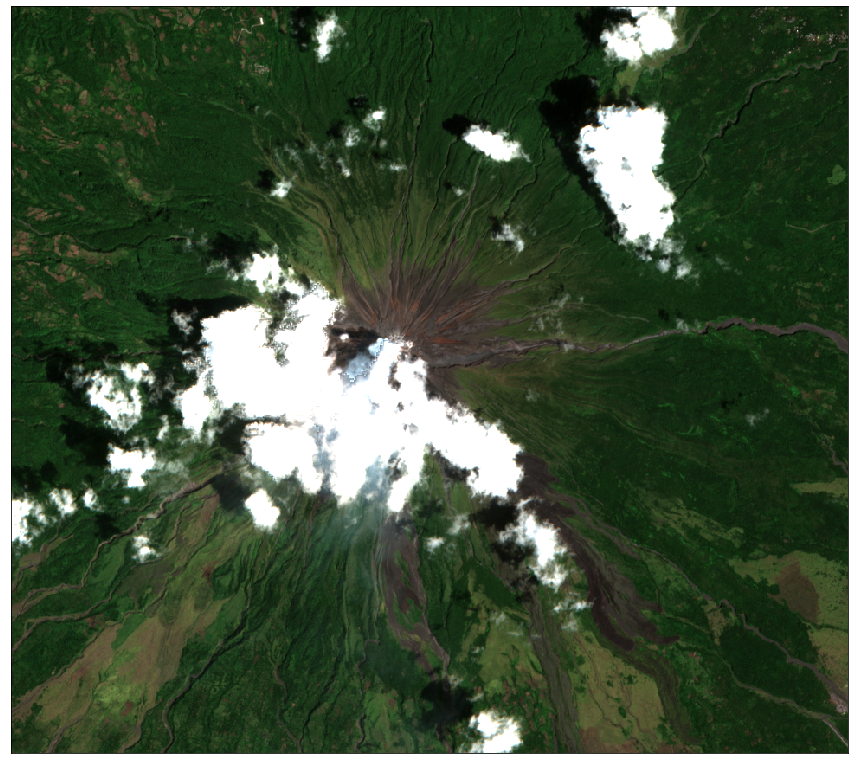

In [17]:
#build request to extract image
request = SentinelHubRequest(
    evalscript=evalscript_true_color,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L2A,
            time_interval=('2020-03-01', '2020-05-31'),
            mosaicking_order='leastCC'
        )
    ],
    responses=[
        SentinelHubRequest.output_response('default', MimeType.PNG)
    ],
    bbox=mayon_bbox,
    size=mayon_size,
    config=config
)

image = request.get_data()[0]

plot_image(image, factor=3.5/255, clip_range=(0,1))

### Example 5: Laguna de Bay (Bounding Box)

In [46]:
# laguna =gpd.read_file('laguna_de_bay.json')
laguna =[121.030334,14.168978,121.493134,14.547036]

In [47]:
resolution =50
laguna_bbox = BBox(bbox=laguna, crs=CRS.WGS84)
laguna_size = bbox_to_dimensions(laguna_bbox, resolution=resolution)

print(f'Image shape at {resolution} m resolution: {laguna_size} pixels')

Image shape at 50 m resolution: (1005, 829) pixels


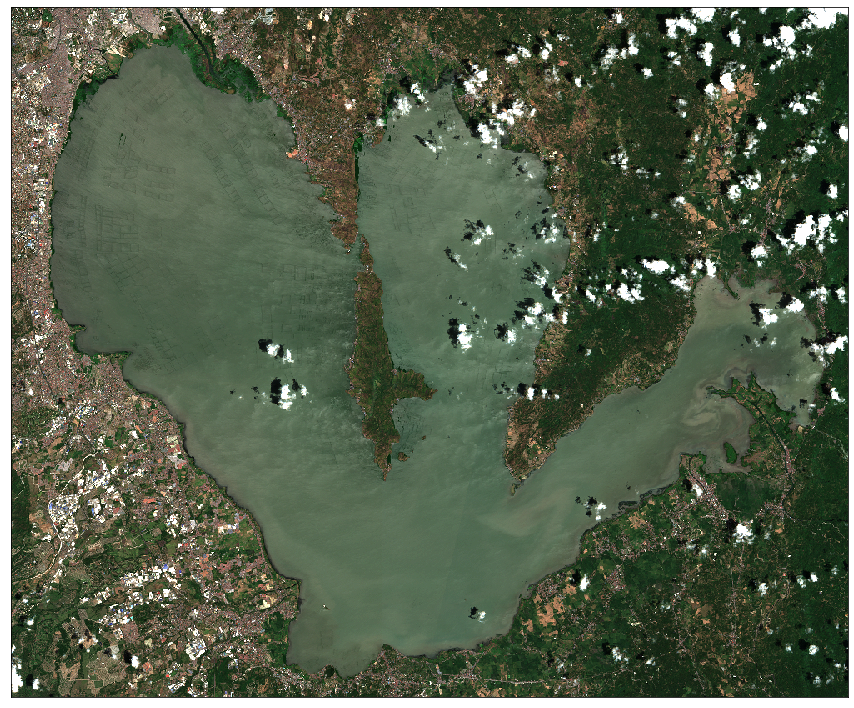

In [50]:
# evalscript for selecting appropriate bands
evalscript_true_color = """
    //VERSION=3
    function setup() {
        return {
            input: [{
                bands: ["B02", "B03", "B04"]
            }],
            output: {
                bands: 3
            }
        };
    }
    function evaluatePixel(sample) {
        return [sample.B04, sample.B03, sample.B02];
    }
"""

# build request to extract image
request = SentinelHubRequest(
    evalscript=evalscript_true_color,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L2A,
            time_interval=('2020-03-01', '2020-05-31'),
            mosaicking_order='leastCC'
        )
    ],
    responses=[
        SentinelHubRequest.output_response('default', MimeType.PNG)
    ],
    bbox=laguna_bbox,
    size=laguna_size,
    config=config
)

image = request.get_data()[0]

# extract true color image of least cloudy acquisitions (tile-level)
plot_image(image, factor=3.5/255, clip_range=(0,1))

### Example 6: Laguna de Bay (Geometry)

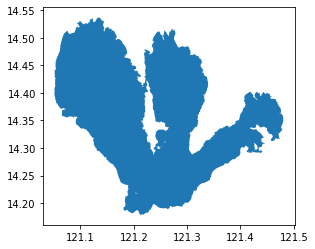

In [56]:
bay = gpd.read_file('laguna_de_bay.geojson')
bay.plot()

In [57]:
bay.head()

geometry
0  POLYGON ((121.10797 14.52560, 121.10852 14.525...

In [58]:
print(bay.crs)

epsg:4326


In [59]:
# initialize Geometry of AOI
bay_geometry = Geometry(bay['geometry'][0], crs=CRS.WGS84)

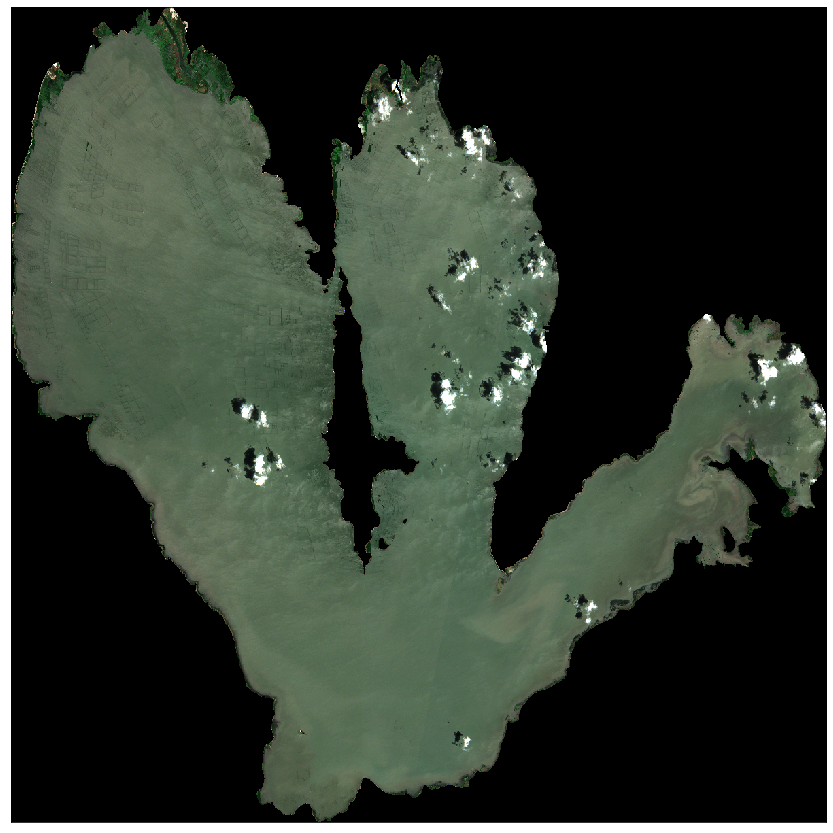

In [60]:
# build request to extract image
request = SentinelHubRequest(
    evalscript=evalscript_true_color,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L2A,
            time_interval=('2020-03-01', '2020-05-31'),
            mosaicking_order='leastCC'
        )
    ],
    responses=[
        SentinelHubRequest.output_response('default', MimeType.PNG)
    ],
    geometry=bay_geometry,
    size=(1200,1200),
    config=config
)

image = request.get_data()[0]

plot_image(image, factor=3.5/255, clip_range=(0,1))

### Example 4: Trial (small spatial extent)

For this example, the AOI is a small field as shown in the image below:

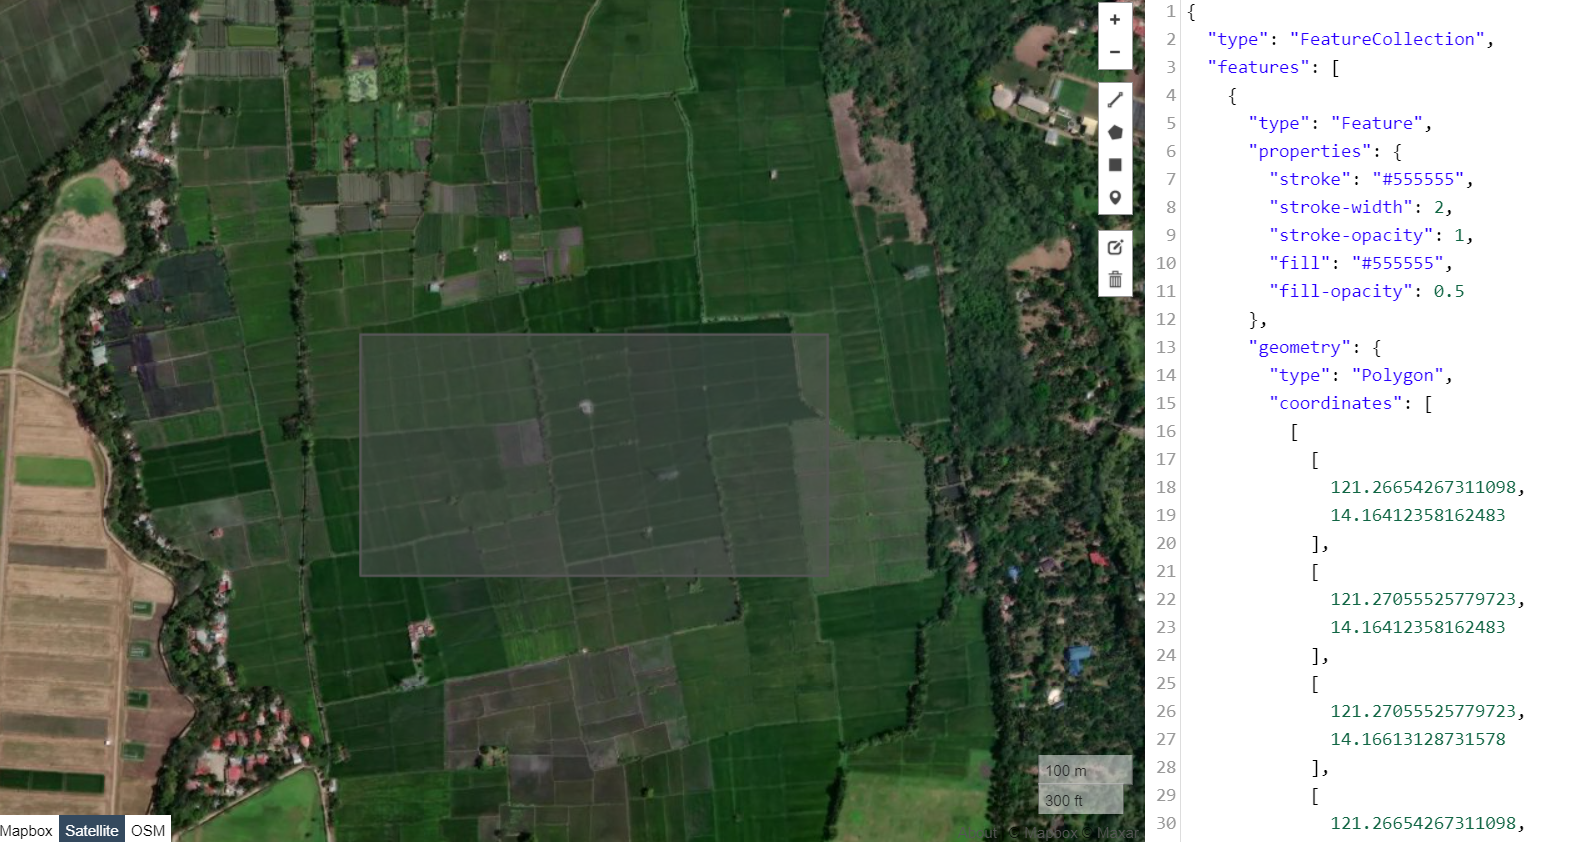

In [24]:
trial = gpd.read_file('map.geojson')

In [19]:
trial

geometry
0  POLYGON ((121.26654 14.16412, 121.27056 14.164...

In [20]:
trial.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

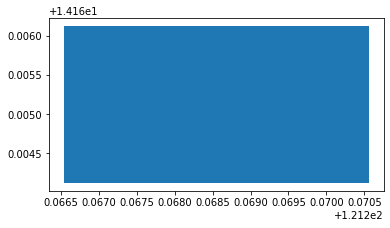

In [21]:
trial.plot()

In [22]:
trial_geometry = Geometry(trial['geometry'][0], CRS.WGS84)

In [35]:
trial = [121.26654267311098,
          14.16412358162483,
          121.27055525779723,
          14.16613128731578]

In [36]:
resolution =10
trial_bbox = BBox(bbox=trial, crs=CRS.WGS84)
trial_size = bbox_to_dimensions(trial_bbox, resolution=resolution)

print(f'Image shape at {resolution} m resolution: {trial_size} pixels')

Image shape at 10 m resolution: (43, 22) pixels


**Satellite images tend to be pixelated when defined spatial extent of AOI becomes significantly small (as shown below). This is a trade-off that needs to be considered when it comes to selecting geographical locations for visualizations.**

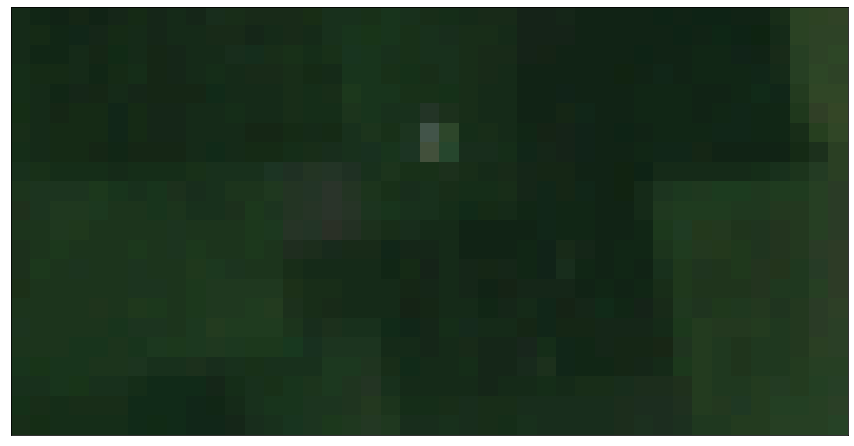

In [37]:
request = SentinelHubRequest(
    evalscript=evalscript_true_color,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L2A,
            time_interval=('2020-03-01', '2020-04-30'),
            mosaicking_order='leastCC'
        )
    ],
    responses=[
        SentinelHubRequest.output_response('default', MimeType.PNG)
    ],
    bbox=trial_bbox,
    size=trial_size,
    config=config
)

image = request.get_data()[0]

plot_image(image, factor=3.5/255, clip_range=(0,1))